In [17]:
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFloat, Int8ActPerTensorFloat


class QuantTinyCNN_FINN(nn.Module):
    def __init__(self):
        super(QuantTinyCNN_FINN, self).__init__()
        quantinfo = {"weight_quant": Int8WeightPerTensorFloat, "weight_bit_width": 8}

        # ⚠️ Eliminamos conv+pool (FINN no lo soporta bien)
        # Usamos solo capas fully-connected cuantizadas

        self.fc1 = qnn.QuantLinear(
            in_features=3 * 64 *64,  # suponiendo imágenes de 32x32 RGB
            out_features=512,
            bias=True,
            **quantinfo
        )
        self.relu1 = qnn.QuantReLU(bit_width=8, act_quant=Int8ActPerTensorFloat)

        self.fc2 = qnn.QuantLinear(
            in_features=512,
            out_features=256,
            bias=True,
            **quantinfo
        )
        self.relu2 = qnn.QuantReLU(bit_width=8, act_quant=Int8ActPerTensorFloat)

        self.fc3 = qnn.QuantLinear(
            in_features=256,
            out_features=100,
            bias=True,
            **quantinfo
        )
        self.relu3 = qnn.QuantReLU(bit_width=8, act_quant=Int8ActPerTensorFloat)

        self.fc4 = qnn.QuantLinear(
            in_features=100,
            out_features=2,  # salida para 2 clases
            bias=True,
            **quantinfo
        )

    def forward(self, x):
        # Aplanar entrada (ya no hay conv)
        x = x.reshape(x.size(0), -1)

        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)

        return x


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


# Función de cuantización
def quantize_tensor(x, num_bits=8):
    qmin = 0.0
    qmax = 2.0**num_bits - 1.0
    min_val, max_val = x.min(), x.max()
    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    return q_x / qmax  # volver a rango [0,1]


class CustomQuantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        class_mapping = {"bird": 0, "no_bird": 1}

        # Recorre las carpetas "bird" y "no_bird"
        for class_name, label in class_mapping.items():
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for file in os.listdir(class_folder):
                if file.endswith((".png", ".jpg", ".jpeg")):
                    self.image_files.append(os.path.join(class_folder, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# Transform cuantizado
from torchvision import transforms

transform_quantized = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3),
        transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: quantize_tensor(x, num_bits=8)),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

val_transform_quantized = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.Lambda(lambda x: quantize_tensor(x, num_bits=8)),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

# Crear datasets y loaders
train_dataset = CustomQuantDataset("dataset_split/train", transform=transform_quantized)
val_dataset = CustomQuantDataset("dataset_split/val", transform=val_transform_quantized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Min: -0.6392157  /// Max: 1.0
dtype: float32


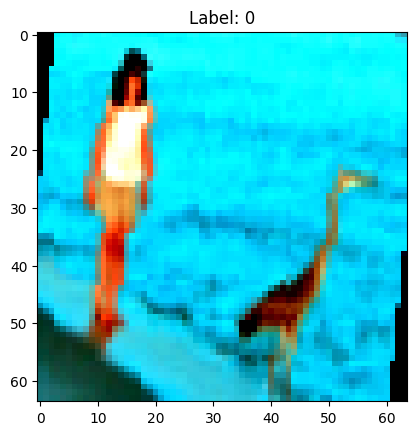

In [19]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[10]  # tu dataset cuantizado
image = np.array(image)
image = np.transpose(image, (1, 2, 0))

print("Min:", np.min(image), " /// Max:", np.max(image))
print("dtype:", image.dtype)

# Plot
plt.figure()
plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()

In [20]:
device = "cpu"
net = QuantTinyCNN_FINN().to(device)
net.train()
num_epochs = 30
criterion = nn.CrossEntropyLoss()  # Para clasificación multiclase
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
for epoch in range(num_epochs):
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 0.6257
Epoch [2/5], Loss: 0.8559


KeyboardInterrupt: 

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os


# Tu dataset de test personalizado
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        class_mapping = {"bird": 0, "no_bird": 1}
        for class_name, label in class_mapping.items():
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for file in os.listdir(class_folder):
                if file.endswith((".png", ".jpg", ".jpeg")):
                    self.image_files.append(os.path.join(class_folder, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# Transform similar al de entrenamiento
transform_test = transforms.Compose(
    [
        transforms.Resize((64, 64)),  # tamaño que tu modelo espera
        transforms.ToTensor(),
        transforms.Lambda(
            lambda x: quantize_tensor(x, num_bits=8)
        ),  # si tu modelo espera cuantización
    ]
)

test_dataset = CustomTestDataset("Images_test", transform=transform_test)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)  # batch 1 para pocas imágenes

# Evaluar
net.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()  # Brevitas puede requerir float
        out = net(images)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Accuracy on custom test set:", accuracy, "%")

Accuracy on custom test set: 73.91304347826087 %


In [14]:
print(net.fc1.quant_weight())  # pesos cuantizados
print(net.fc1.quant_weight().int()) 
print(net.fc1.quant_weight().int().dtype) 

QuantTensor(value=tensor([[ 0.0364,  0.0390,  0.0264,  ..., -0.0038,  0.0038,  0.0050],
        [ 0.0025,  0.0013,  0.0013,  ...,  0.0302,  0.0138,  0.0276],
        [ 0.0101,  0.0088, -0.0013,  ...,  0.0163,  0.0201,  0.0251],
        ...,
        [ 0.0013,  0.0138,  0.0088,  ...,  0.0013,  0.0013,  0.0038],
        [ 0.0214,  0.0264,  0.0390,  ...,  0.0201,  0.0201,  0.0188],
        [ 0.0101,  0.0050, -0.0088,  ...,  0.0239,  0.0352,  0.0402]],
       grad_fn=<MulBackward0>), scale=tensor(0.0013, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(True), training_t=tensor(False))
tensor([[29, 31, 21,  ..., -3,  3,  4],
        [ 2,  1,  1,  ..., 24, 11, 22],
        [ 8,  7, -1,  ..., 13, 16, 20],
        ...,
        [ 1, 11,  7,  ...,  1,  1,  3],
        [17, 21, 31,  ..., 16, 16, 15],
        [ 8,  4, -7,  ..., 19, 28, 32]], dtype=torch.int8)
torch.int8


In [15]:
import os
import torch
import numpy as np
from PIL import Image
import brevitas.nn as qnn
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN


user_name = "parasyte" # REPLACE THIS WITH YOUR HOST MACHINE USER NAME 
root_dir = f"/tmp/finn_dev_{user_name}"
     

# -------------------------
# Configuración
# -------------------------
dataset_path = "Images_test"  # Carpeta con tus imágenes
image_size = (64, 64)  # Cambia según tu dataset
num_bits = 8  # Cuantización

# -------------------------
# Función de cuantización asimétrica
# -------------------------
def asymmetric_quantize(arr, num_bits=8):
    min_val = 0
    max_val = 2**num_bits - 1

    beta = np.min(arr)
    alpha = np.max(arr)
    scale = (alpha - beta) / max_val
    zero_point = np.clip((-beta / scale), 0, max_val).round().astype(np.int8)

    quantized_arr = np.clip(
        np.round(arr / scale + zero_point), min_val, max_val
    ).astype(np.float32)
    return quantized_arr

# -------------------------
# Cargar una imagen y preprocesar
# -------------------------
def load_and_quantize_image(file_path):
    img = Image.open(file_path).convert("RGB")
    img = img.resize(image_size)
    img_arr = np.array(img).astype(np.float32) / 255.0  # normalización a 0-1
    img_arr = img_arr.transpose(2, 0, 1)  # (H,W,C) -> (C,H,W)
    img_q = asymmetric_quantize(img_arr, num_bits=num_bits)
    return img_q

# -------------------------
# Obtener lista solo de imágenes
# -------------------------
def get_image_files_recursive(folder):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")
    image_files = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(valid_extensions):
                image_files.append(os.path.join(root, f))
    return image_files

image_files = get_image_files_recursive(dataset_path)
if not image_files:
    raise RuntimeError("No se encontraron imágenes en la carpeta.")


# -------------------------
# Crear tensor de entrada usando la primera imagen
# -------------------------
example_image = load_and_quantize_image(image_files[0])
input_t = torch.from_numpy(example_image).unsqueeze(0)  # batch dimension

# -------------------------
# Exportar modelo Brevitas a QONNX
# -------------------------
# Asegúrate de que tu modelo cuantizado exista como `net`
filename_onnx = os.path.join(root_dir, "part1.onnx")
filename_clean = os.path.join(root_dir, "part1_clean.onnx")

export_qonnx(net, export_path=filename_onnx, input_t=input_t)

# -------------------------
# Limpiar ONNX para FINN
# -------------------------
qonnx_cleanup(filename_onnx, out_file=filename_clean)

# -------------------------
# Convertir a FINN
# -------------------------
model_finn = ModelWrapper(filename_clean)
model_finn = model_finn.transform(ConvertQONNXtoFINN())
model_finn.save(os.path.join(root_dir, "ready_finn.onnx"))

print("Modelo exportado a FINN en: " + os.path.join(root_dir, "ready_finn.onnx"))


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.